In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, QuantileTransformer
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_curve, auc, precision_recall_curve, average_precision_score, 
                           balanced_accuracy_score, f1_score, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.utils import resample
from sklearn.base import clone
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

# Data balancing
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

# Plot style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'

### Data loading and initial analysis

In [3]:
df = pd.read_csv("./Dataset/Dataset.csv")
df.head(3)

,PIPE_NO,DV_R,DA_R,AV_R,AA_R,PM_R,FIN_JGMT
0,PP22033000042,318,7798,365,7177,9507,1
1,PP22033000042,318,7798,365,7177,9507,1
2,PP22033000042,316,8479,380,8846,9484,1


In [4]:
print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Missing values: {df.isnull().sum().sum()}")

Dataset size: 739888 rows, 7 columns
Missing values: 0


In [5]:
# Class analysis
class_counts = df['FIN_JGMT'].value_counts()
print(f"\nClass distribution:")
print(f"Normal (1): {class_counts[1]} ({class_counts[1]/len(df)*100:.1f}%)")
print(f"Defects (0): {class_counts[0]} ({class_counts[0]/len(df)*100:.1f}%)")
print(f"Ratio (normal:defect): {class_counts[1]/class_counts[0]:.2f}:1")


Class distribution:
Normal (1): 626092 (84.6%)
Defects (0): 113796 (15.4%)
Ratio (normal:defect): 5.50:1


### PLOT 1: Class distribution with improved visualization

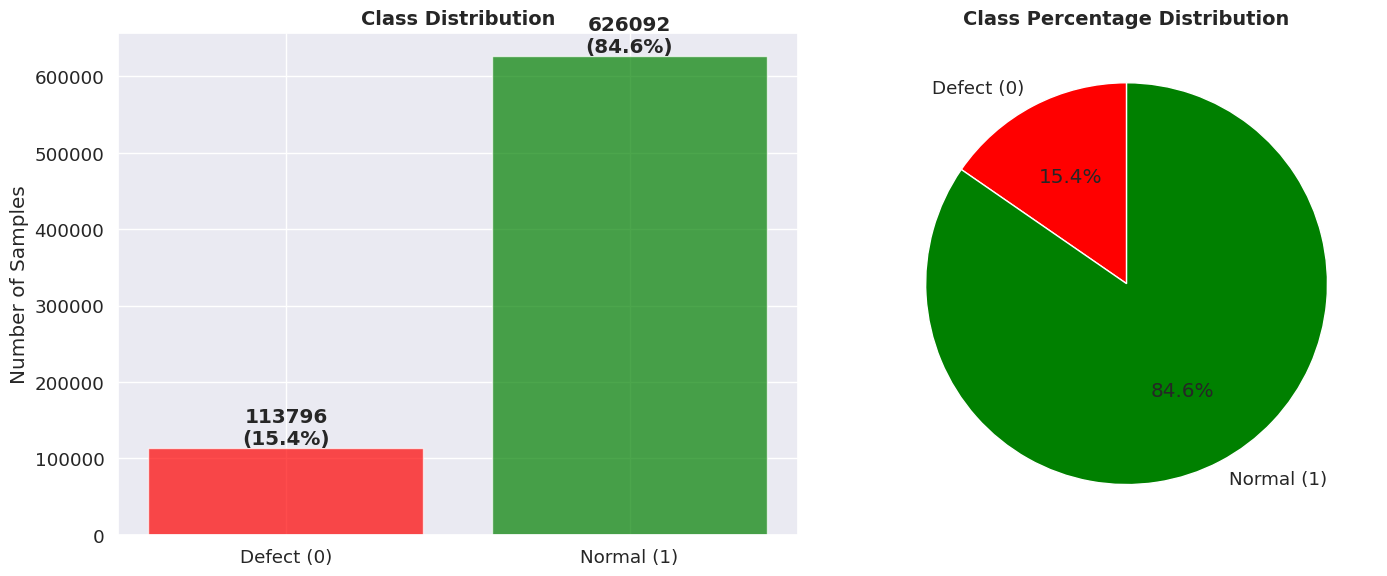

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 6])

# Bar chart
ax1.bar(['Defect (0)', 'Normal (1)'], [class_counts[0], class_counts[1]], 
        color=['red', 'green'], alpha=0.7)
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Samples')
for i, v in enumerate([class_counts[0], class_counts[1]]):
    ax1.text(i, v + 50, f'{v}\n({v/len(df)*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2.pie([class_counts[0], class_counts[1]], labels=['Defect (0)', 'Normal (1)'], 
        colors=['red', 'green'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Class Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### # PLOT 2: Statistical description of features

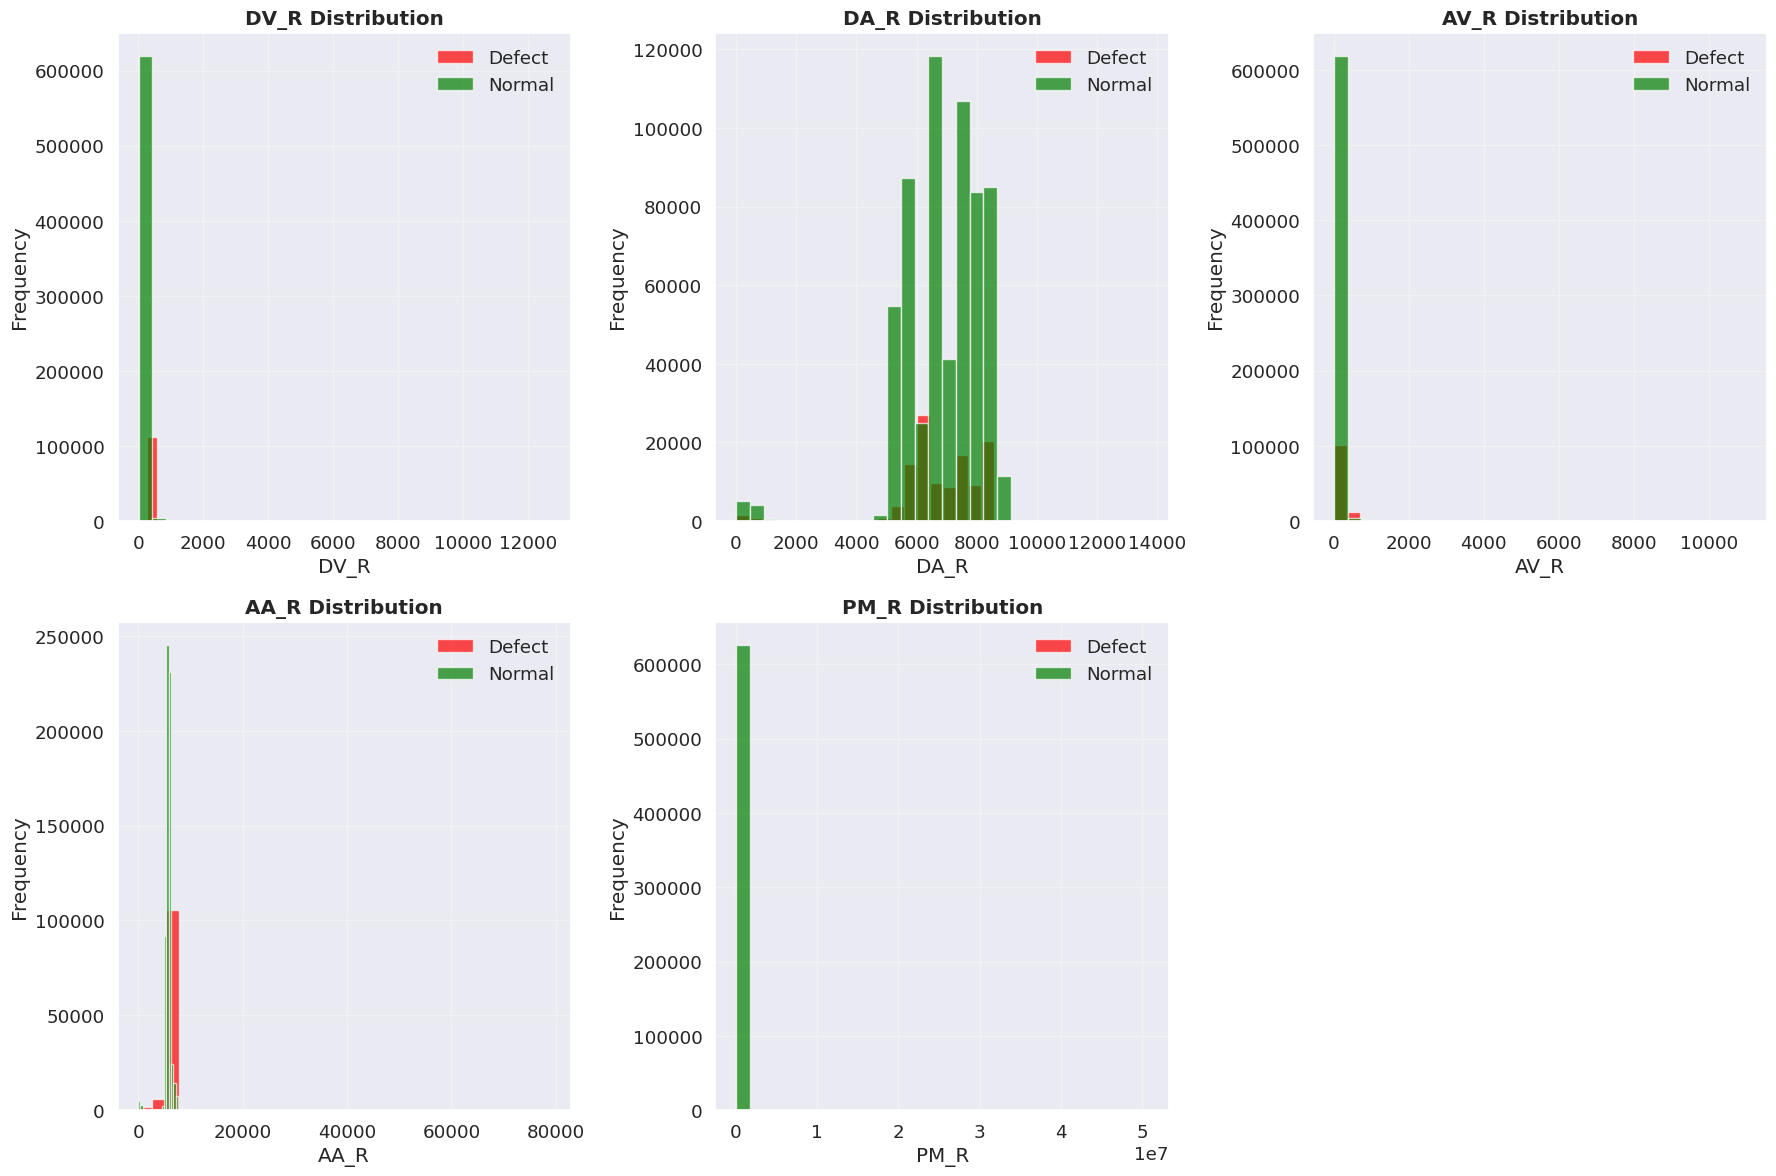

In [7]:
feature_cols = ['DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R']
fig, axes = plt.subplots(2, 3, figsize=[18, 12])
axes = axes.ravel()

for i, col in enumerate(feature_cols):
    # Histogram with class separation
    df[df['FIN_JGMT'] == 0][col].hist(bins=30, alpha=0.7, label='Defect', color='red', ax=axes[i])
    df[df['FIN_JGMT'] == 1][col].hist(bins=30, alpha=0.7, label='Normal', color='green', ax=axes[i])
    axes[i].set_title(f'{col} Distribution', fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Remove extra subplot
axes[5].remove()
plt.tight_layout()
plt.show()

### PLOT 3: Boxplot for outlier detection

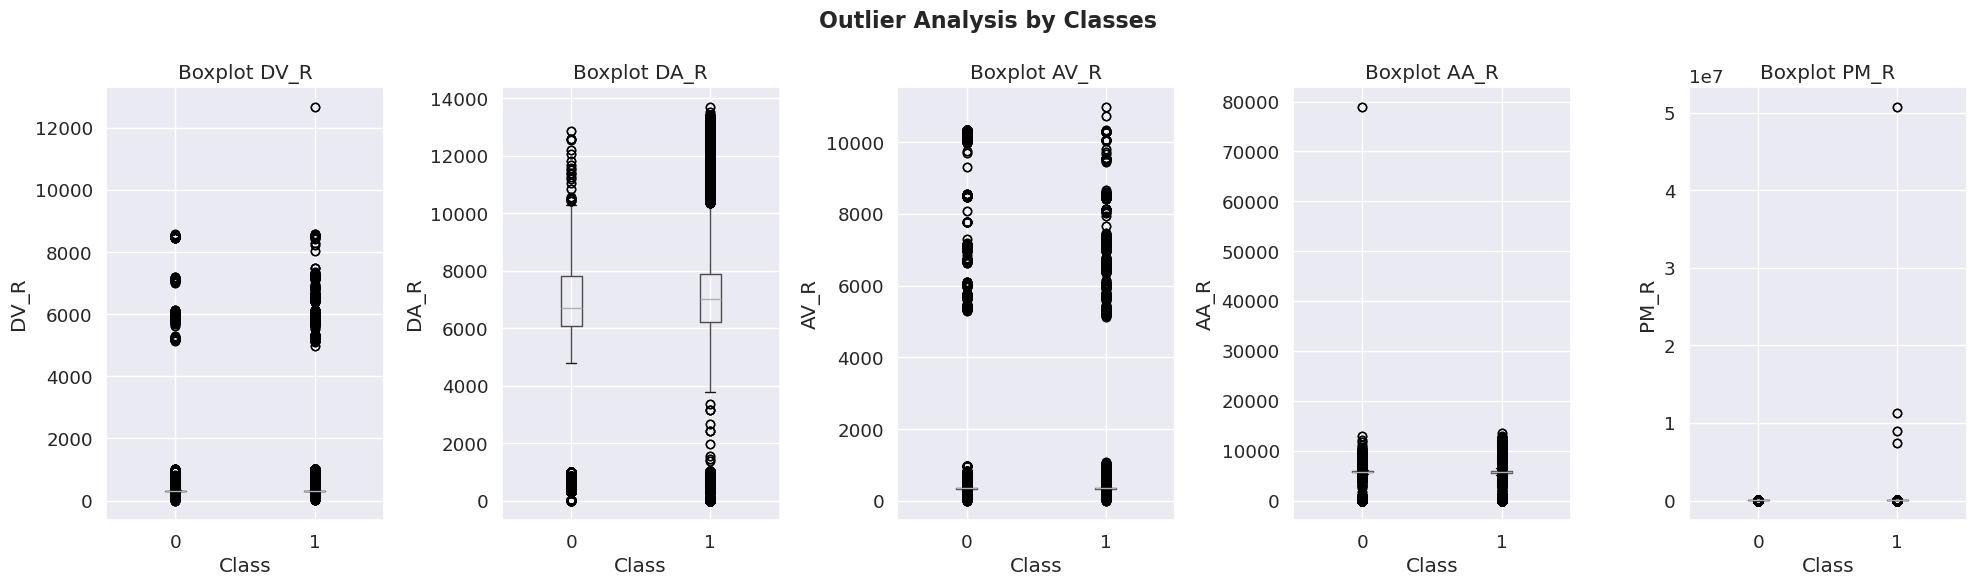

In [9]:
fig, axes = plt.subplots(1, 5, figsize=[20, 6])
for i, col in enumerate(feature_cols):
    df.boxplot(column=col, by='FIN_JGMT', ax=axes[i])
    axes[i].set_title(f'Boxplot {col}')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(col)
plt.suptitle('Outlier Analysis by Classes', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Data preparation

In [17]:
X = df[feature_cols]
y = df['FIN_JGMT']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nSample sizes:")
print(f"Training: {X_train.shape}, Testing: {X_test.shape}")


Sample sizes:
Training: (591910, 5), Testing: (147978, 5)


### PLOT 4: Correlation matrix

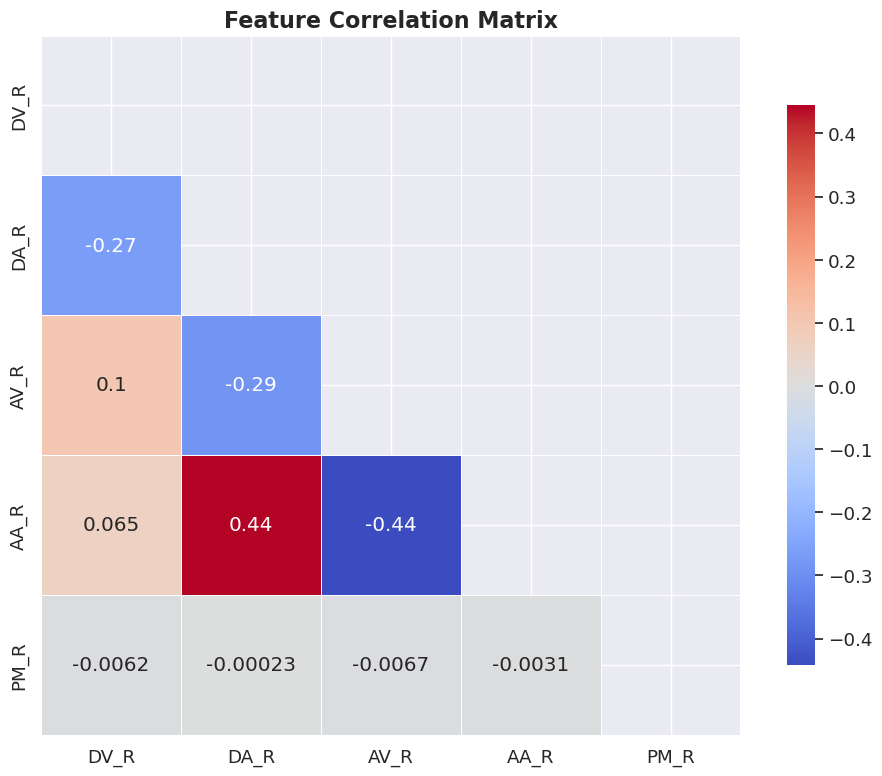

In [18]:
plt.figure(figsize=(10, 8))
corr_matrix = df[feature_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Comparison of normalization methods

In [19]:
normalization_methods = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal')
}

#### Testing normalization methods

In [20]:
normalization_results = {}
scaled_data = {}

for name, scaler in normalization_methods.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaled_data[name] = (X_train_scaled, X_test_scaled)
    
    # Base model for testing
    model = LogisticRegression(random_state=42, max_iter=1000, 
                              class_weight={0: 100, 1: 0.1})
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=0)
    
    normalization_results[name] = {'accuracy': accuracy, 'f1_score': f1}
    print(f"{name}: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")


StandardScaler: Accuracy = 0.1538, F1 = 0.2666
MinMaxScaler: Accuracy = 0.1538, F1 = 0.2666
RobustScaler: Accuracy = 0.1538, F1 = 0.2666
Normalizer: Accuracy = 0.1538, F1 = 0.2666
QuantileTransformer: Accuracy = 0.1538, F1 = 0.2666


### PLOT 5: Normalization methods comparison

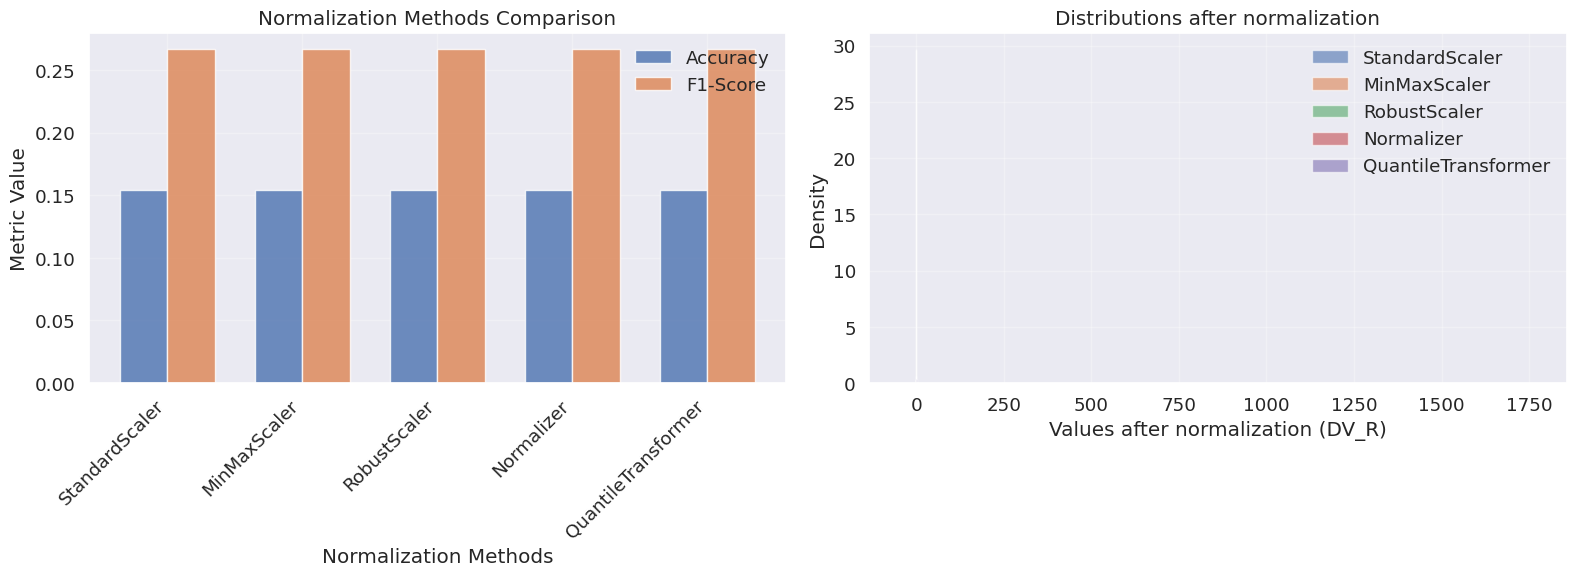

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
methods = list(normalization_results.keys())
accuracies = [normalization_results[m]['accuracy'] for m in methods]
f1_scores = [normalization_results[m]['f1_score'] for m in methods]

x = np.arange(len(methods))
width = 0.35

ax1.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
ax1.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8)
ax1.set_xlabel('Normalization Methods')
ax1.set_ylabel('Metric Value')
ax1.set_title('Normalization Methods Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distribution visualization after normalization
for i, (name, (X_scaled, _)) in enumerate(scaled_data.items()):
    if i < 5:  # Show first 5 methods
        ax2.hist(X_scaled[:, 0], bins=30, alpha=0.6, label=name, density=True)

ax2.set_xlabel('Values after normalization (DV_R)')
ax2.set_ylabel('Density')
ax2.set_title('Distributions after normalization')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Select best method
best_method = max(normalization_results.items(), key=lambda x: x[1]['f1_score'])[0]
print(f"\nBest normalization method: {best_method}")


Best normalization method: StandardScaler


In [23]:
best_scaler = normalization_methods[best_method]
X_train_scaled = best_scaler.fit_transform(X_train)
X_test_scaled = best_scaler.transform(X_test)

### 5. Outlier analysis

In [24]:
# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_predictions = iso_forest.fit_predict(X)
outliers_count = np.sum(outlier_predictions == -1)
print(f"Outliers detected: {outliers_count} out of {len(X)} ({outliers_count/len(X)*100:.1f}%)")

Outliers detected: 36994 out of 739888 (5.0%)


### PLOT 6: Outlier analysis

  File "C:\Users\User\anaconda3\envs\internship_2\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


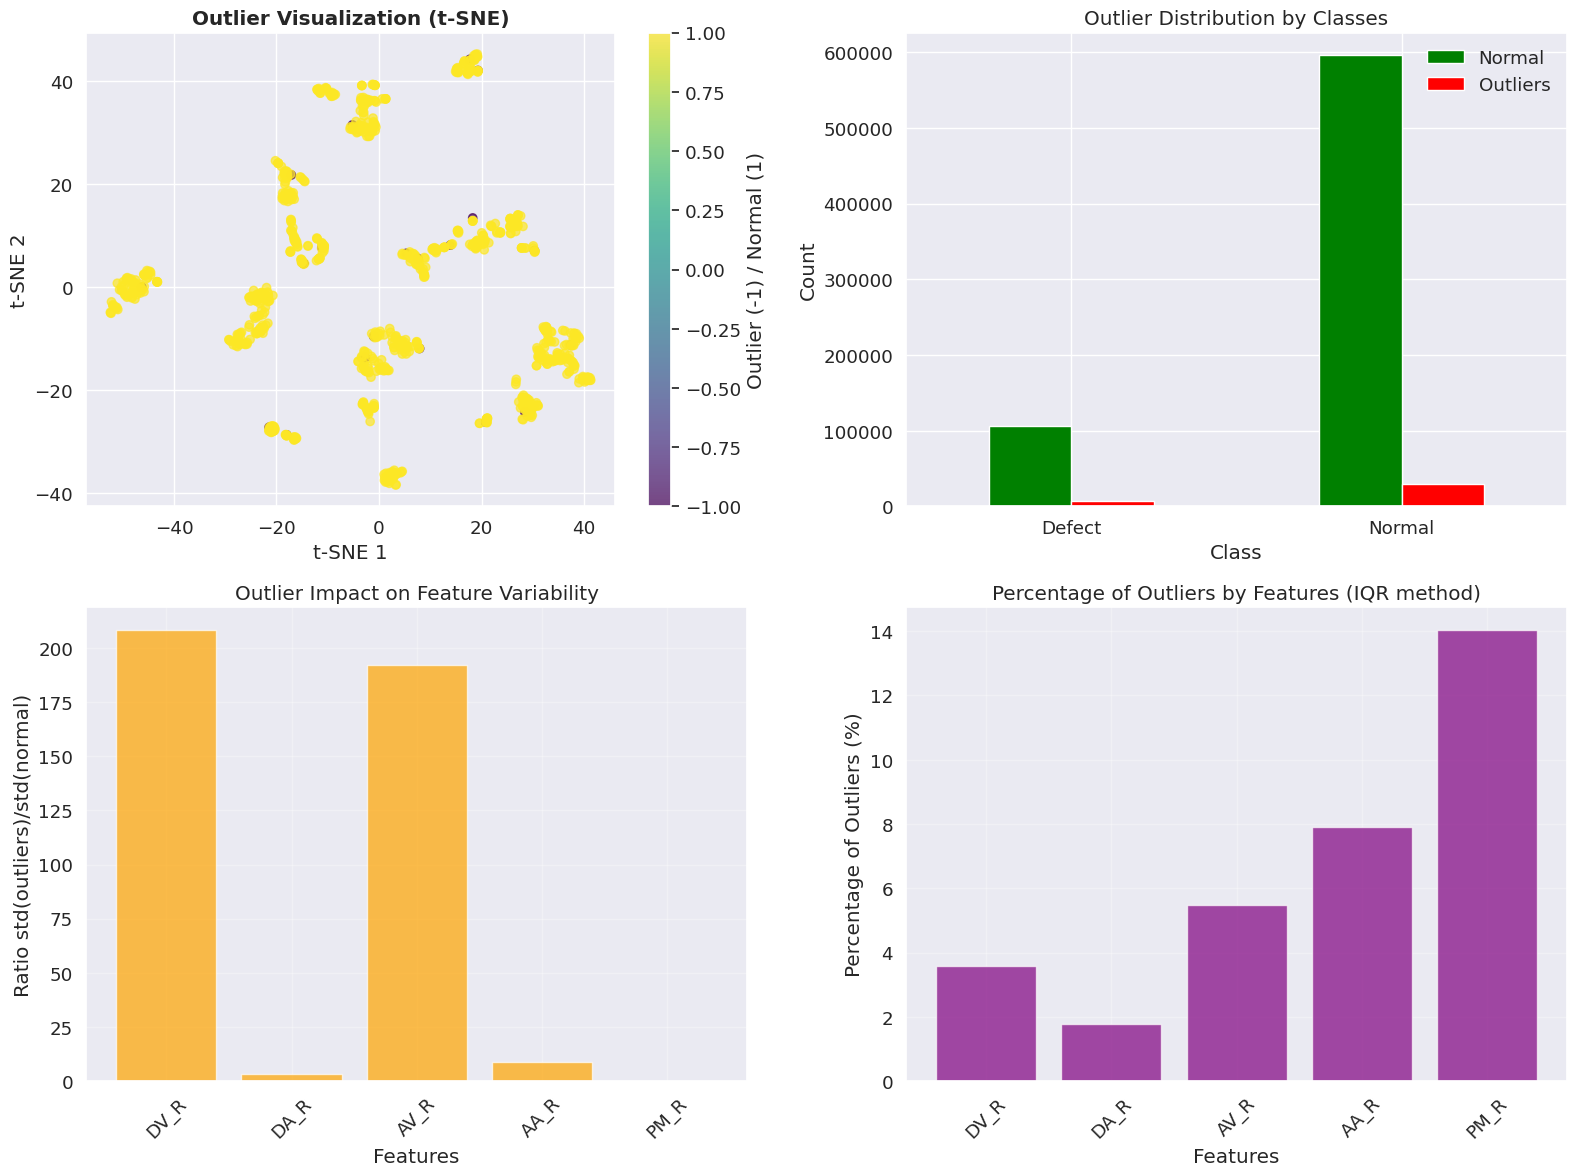

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# t-SNE outlier visualization
tsne = TSNE(n_components=2, random_state=42)
X_sample = X.sample(1000, random_state=42)
outlier_sample = outlier_predictions[:1000]
X_tsne = tsne.fit_transform(X_sample)

scatter = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=outlier_sample, cmap='viridis', alpha=0.7)
ax1.set_title('Outlier Visualization (t-SNE)', fontweight='bold')
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')
plt.colorbar(scatter, ax=ax1, label='Outlier (-1) / Normal (1)')

# Outlier distribution by classes
df_outliers = df.copy()
df_outliers['is_outlier'] = outlier_predictions
df_outliers['is_outlier'] = df_outliers['is_outlier'].map({1: 0, -1: 1})

outlier_by_class = df_outliers.groupby(['FIN_JGMT', 'is_outlier']).size().unstack(fill_value=0)
outlier_by_class.plot(kind='bar', ax=ax2, color=['green', 'red'])
ax2.set_title('Outlier Distribution by Classes')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.legend(['Normal', 'Outliers'])
ax2.set_xticklabels(['Defect', 'Normal'], rotation=0)

# Outlier impact on features
outlier_impact = []
for col in feature_cols:
    normal_std = df_outliers[df_outliers['is_outlier'] == 0][col].std()
    outlier_std = df_outliers[df_outliers['is_outlier'] == 1][col].std()
    outlier_impact.append(outlier_std / normal_std if normal_std > 0 else 0)

ax3.bar(feature_cols, outlier_impact, color='orange', alpha=0.7)
ax3.set_title('Outlier Impact on Feature Variability')
ax3.set_xlabel('Features')
ax3.set_ylabel('Ratio std(outliers)/std(normal)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Percentage of outliers by features (IQR method)
iqr_outliers = []
for col in feature_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    iqr_outliers.append(outliers / len(df) * 100)

ax4.bar(feature_cols, iqr_outliers, color='purple', alpha=0.7)
ax4.set_title('Percentage of Outliers by Features (IQR method)')
ax4.set_xlabel('Features')
ax4.set_ylabel('Percentage of Outliers (%)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6. Data balancing

In [26]:
balancing_methods = {
    'Original': None,
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

###  PLOT 7: Balancing effect visualization

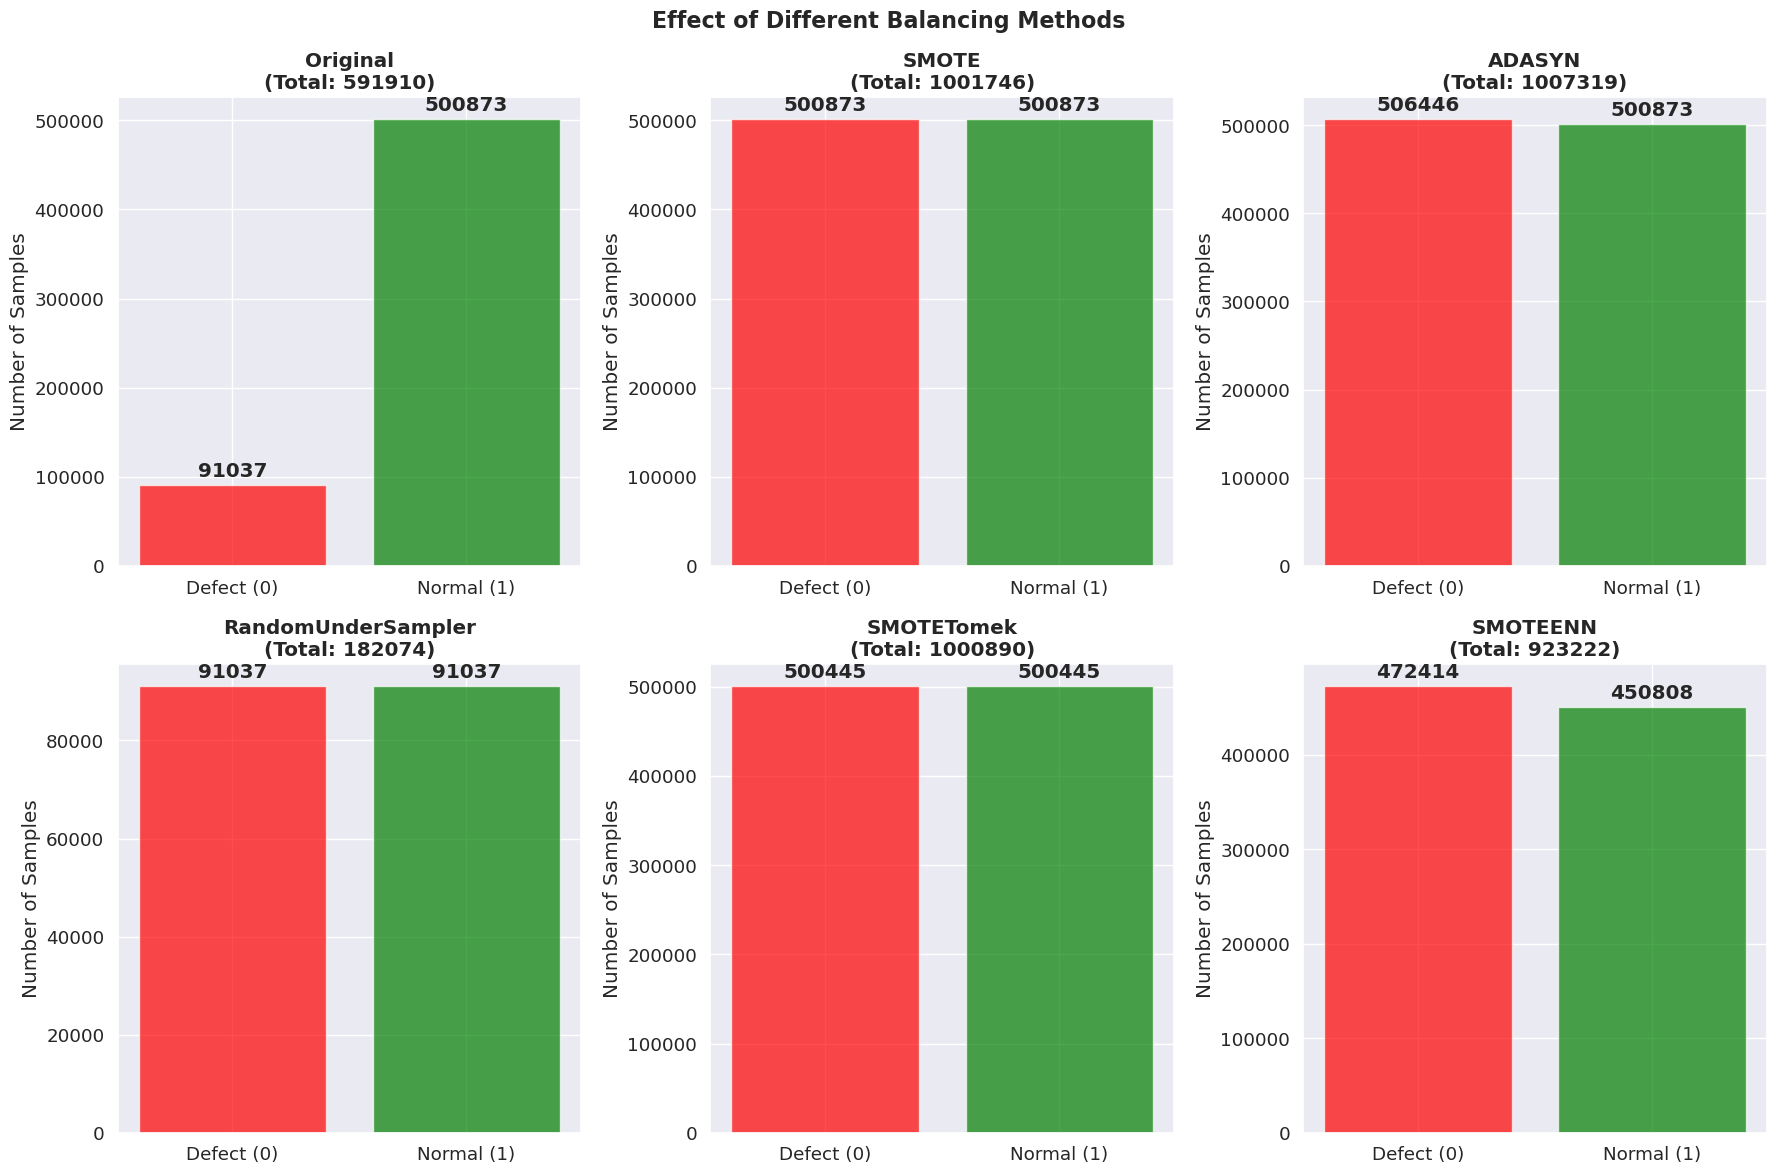

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()  # This line was missing!

for i, (name, balancer) in enumerate(balancing_methods.items()):
    if i >= len(axes):  # Safety check for subplot count
        break
        
    try:
        if balancer is None:
            X_balanced, y_balanced = X_train_scaled, y_train
        else:
            X_balanced, y_balanced = balancer.fit_resample(X_train_scaled, y_train)
        
        # Debug: Check if y_balanced is actually data
        if callable(y_balanced):
            print(f"Error: {name} returned a function instead of data")
            continue
            
        # Convert to numpy array if needed
        if hasattr(y_balanced, 'values'):
            y_balanced = y_balanced.values
        
        # Count classes after balancing
        class_counts_balanced = pd.Series(y_balanced).value_counts().sort_index()
        
        # Get class counts safely
        count_0 = class_counts_balanced.get(0, 0)
        count_1 = class_counts_balanced.get(1, 0)
        
        axes[i].bar(['Defect (0)', 'Normal (1)'], 
                    [count_0, count_1],
                    color=['red', 'green'], alpha=0.7)
        
        # Safe length calculation
        total_samples = len(y_balanced) if hasattr(y_balanced, '__len__') else 'Unknown'
        axes[i].set_title(f'{name}\n(Total: {total_samples})', fontweight='bold')
        axes[i].set_ylabel('Number of Samples')
        
        # Add values on bars with safe max calculation
        if len(class_counts_balanced) > 0:
            max_count = class_counts_balanced.max()
        else:
            max_count = max(count_0, count_1) if (count_0 > 0 or count_1 > 0) else 1
            
        for j, v in enumerate([count_0, count_1]):
            if v > 0:
                axes[i].text(j, v + max_count * 0.01, str(v), 
                            ha='center', va='bottom', fontweight='bold')
                            
    except Exception as e:
        print(f"Error processing {name}: {e}")
        print(f"Type of y_balanced: {type(y_balanced) if 'y_balanced' in locals() else 'Not defined'}")
        axes[i].text(0.5, 0.5, f"Error: {name}", ha='center', va='center', transform=axes[i].transAxes)

plt.suptitle('Effect of Different Balancing Methods', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()